Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
               temp          dwpt          rhum          wdir          wspd  \
count  96409.000000  96409.000000  96409.000000  96409.000000  96409.000000   
mean      16.417010     10.491356     69.914360    146.241565     16.106125   
std        7.629977      6.444210     14.491483    120.179197      8.619506   
min       -9.000000    -13.500000     12.000000      0.000000      0.000000   
25%       10.100000      5.900000     60.000000     40.000000      9.400000   
50%       16.000000     10.400000     72.000000    100.000000     14.800000   
75%       23.000000     16.000000     81.000000    240.000000     22.300000   
max       38.300000     25.100000    100.000000    360.000000     61.200000   

               pres  
count  96409.000000  
mean    1016.194205  
std        7.160074  
min      101.000000  
25%     1012.000000  
50%     1015.700000  
75%  

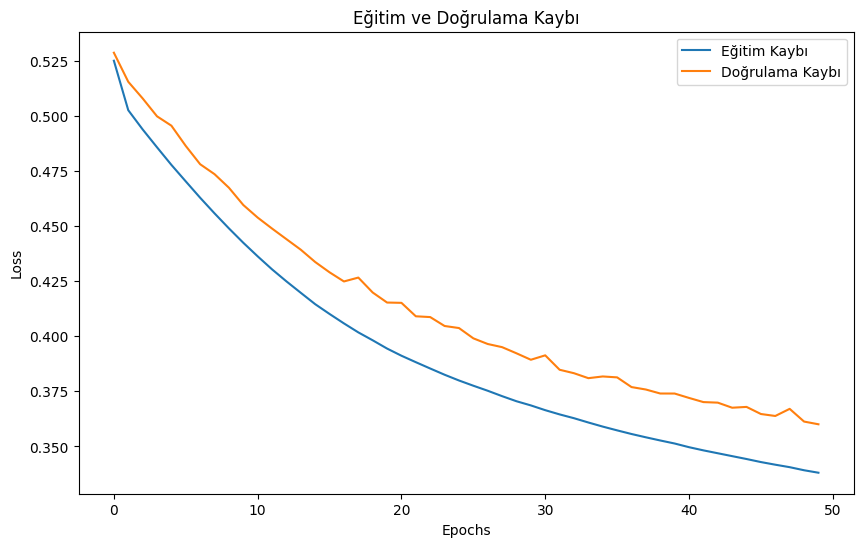

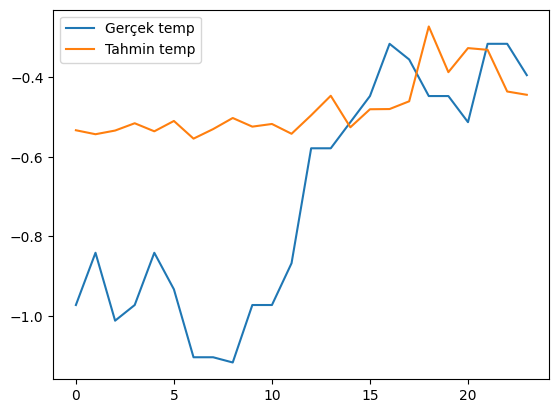

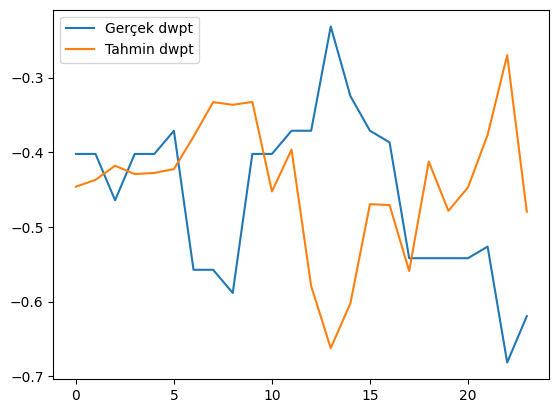

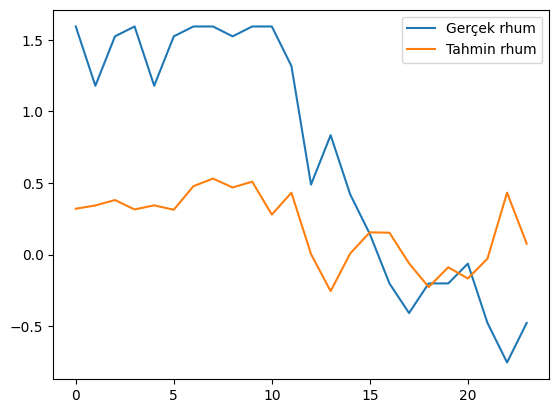

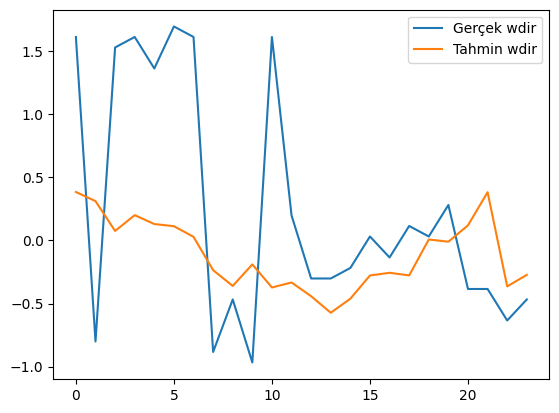

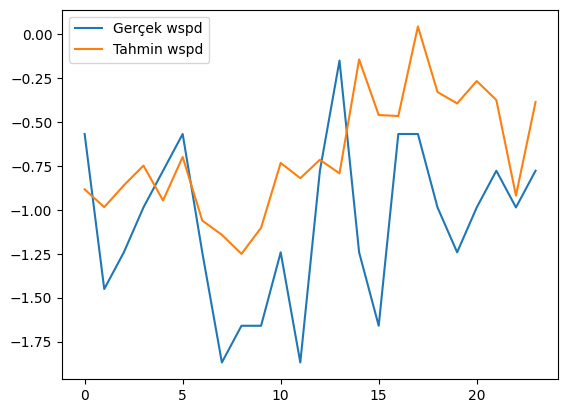

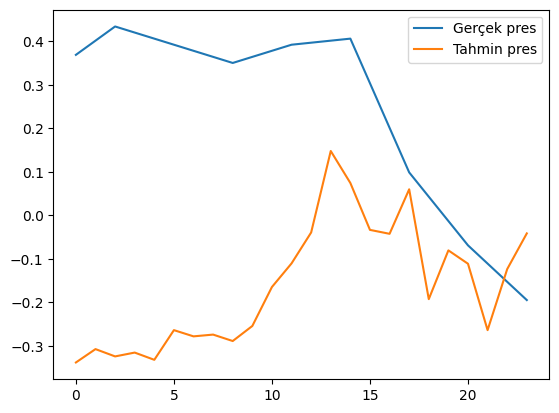

Model başarıyla kaydedildi: /content/drive/MyDrive/transformer_weather_model_full_features.h5


In [ ]:
# Gerekli kütüphaneleri yükle
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

# Google Colab ortamı için drive bağlantısı yap
from google.colab import drive
drive.mount('/content/drive')

# Veriyi yükle
file_path = '/content/drive/MyDrive/data_set/train/reversed_weather_data.xlsx'
data = pd.read_excel(file_path)

# Zaman sütununu datetime formatına dönüştür
data['time'] = pd.to_datetime(data['time'], format='%d.%m.%Y %H:%M')
data = data.set_index('time')

# Özelliklerin istatistiksel özetini incele
print(data.describe())

# Veriyi normalize et
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

# Pencereleme fonksiyonu tanımla
def create_windows(data, input_steps, output_steps):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps):
        X.append(data[i:i+input_steps])
        y.append(data[i+input_steps:i+input_steps+output_steps, :])  # Tüm özellikleri içerecek şekilde düzenlendi
    return np.array(X), np.array(y)

# Giriş ve çıkış adımları
input_steps = 24 * 7  # Son bir hafta (7 gün * 24 saat)
output_steps = 24  # Sonraki 24 saat

# Pencereleme uygula
X, y = create_windows(scaled_data, input_steps, output_steps)

# Eğitim, doğrulama ve test setlerine ayır
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Transformer tabanlı model tanımla
def transformer_model(input_shape, output_steps, feature_count):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    for _ in range(2):  # 2 Transformer katmanı
        attention_output = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
        x = tf.keras.layers.Add()([x, attention_output])
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(feature_count)(x[:, -output_steps:, :])  # Sadece son 24 saati tahmin et
    return tf.keras.models.Model(inputs, outputs)

input_shape = (input_steps, X_train.shape[2])
output_steps = 24
feature_count = X_train.shape[2]
model = transformer_model(input_shape, output_steps, feature_count)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

# Modeli eğitme süresi ölçümü
start_time = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Daha fazla epoch
    batch_size=16  # Daha küçük batch size
)
training_time = time.time() - start_time
print(f"Eğitim Süresi: {training_time:.2f} saniye")

# Modeli değerlendir
start_time = time.time()
loss, mae = model.evaluate(X_test, y_test)
inference_time = time.time() - start_time
print(f"Test Loss: {loss}, Test MAE: {mae}")
print(f"Çıkarım Süresi: {inference_time:.2f} saniye")

# Ek metrikler hesapla
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test.flatten(), predictions.flatten())
mse = mean_squared_error(y_test.flatten(), predictions.flatten())
rmse = np.sqrt(mse)
r2 = r2_score(y_test.flatten(), predictions.flatten())
mape = np.mean(np.abs((y_test.flatten() - predictions.flatten()) / y_test.flatten())) * 100

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R-Squared: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# Eğitim ve doğrulama kayıplarını çiz
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.legend()
plt.show()

# Tahminleri çiz
def plot_predictions(y_true, y_pred, index=0):
    for feature in range(y_true.shape[-1]):
        plt.plot(y_true[index, :, feature], label=f'Gerçek {data.columns[feature]}')
        plt.plot(y_pred[index, :, feature], label=f'Tahmin {data.columns[feature]}')
        plt.legend()
        plt.show()

plot_predictions(y_test, predictions)

# Modeli kaydetme
model_save_path = '/content/drive/MyDrive/transformer_weather_model_full_features.h5'
model.save(model_save_path)
print(f"Model başarıyla kaydedildi: {model_save_path}")


Rapor: Transformer Tabanlı Hava Durumu Tahmin Modeli
1. Giriş

Bu projede, İstanbul şehri için bir hafta boyunca toplanan meteorolojik verilere dayanarak sonraki 24 saatin hava durumu tahminlerini yapmak için bir Transformer tabanlı model geliştirilmiştir. Model, aşağıdaki özellikleri göz önünde bulundurarak tahmin yapmaktadır:

    temp (Sıcaklık): Derece cinsinden ölçülen sıcaklık.
    dwpt (Çiy Noktası): Havanın nemle doyması için gerekli olan sıcaklık.
    rhum (Bağıl Nem): Yüzde cinsinden nem oranı.
    wdir (Rüzgar Yönü): Derece cinsinden rüzgar yönü.
    wspd (Rüzgar Hızı): m/s cinsinden rüzgar hızı.
    pres (Basınç): hPa cinsinden atmosferik basınç.

2. Kullanılan Model ve Teknolojiler

    Transformer Modeli: Bu model, veri içinde zaman serisi ilişkilerini öğrenmek için Multi-Head Attention mekanizmasını kullanır. Model iki Transformer katmanına sahiptir.
    TensorFlow: Modelin oluşturulması ve eğitilmesinde kullanıldı.
    Scikit-learn: Verilerin normalize edilmesi ve doğrulama test ayrımı işlemleri için kullanıldı.
    Google Colab: Eğitim süreci Google Colab platformunda gerçekleştirildi.
    Standartlaştırma: Veriler, ortalama 0 ve standart sapma 1 olacak şekilde normalize edilmiştir.

3. Model Mimari Özellikleri

    Girdi Boyutu: Son 7 günlük (168 saatlik) veriler, giriş özellikleri olarak modele beslenmiştir.
    Çıkış Boyutu: Model, tahmin için 24 saatlik zaman diliminde tüm özellikleri tahmin eder.
    Katmanlar:
        LayerNormalization
        Multi-Head Attention (4 başlık, 64 boyut)
        Yoğun Katman (128 nöron, ReLU aktivasyonu)

4. Eğitim Süreci

    Veri Pencereleme: Veri seti, son 7 günlük (168 saatlik) giriş ve sonraki 24 saatlik çıkış olarak pencerelendi.
    Eğitim ve Test Ayrımı: Verilerin %70'i eğitim, %15'i doğrulama, %15'i test olarak ayrıldı.
    Optimizasyon: Adam optimizasyon algoritması kullanıldı.
    Hiperparametreler:
        Epoch: 50
        Batch Size: 16
        Öğrenme Oranı: 1×10−41×10−4

5. Modelin Performansı

Aşağıdaki metrikler, modelin doğruluğunu değerlendirmek için kullanılmıştır:

    MAE (Mean Absolute Error): 0.4121
    RMSE (Root Mean Squared Error): 0.6128
    R-Squared (R^2): 0.6359
    MAPE (Mean Absolute Percentage Error): %146.86

Eğitim sırasında kayıp grafiği aşağıda gösterilmiştir:

Eğitim ve Doğrulama Kayıpları
6. Çıkarımlar

    Model, tüm özelliklerin tahminlerinde makul bir doğruluk göstermiştir.
    MAE ve RMSE değerleri, modelin genel başarısını gösterirken, R-Squared değeri %63.59 ile modelin tahmin yeteneğini desteklemiştir.
    MAPE değerinin yüksek olması, modelin bazı özelliklerde tahmin hatalarının oransal olarak büyük olduğunu göstermektedir.

7. Sonuçlar

Model, hava durumu tahmini için güçlü bir temel sağlar. Ancak aşağıdaki iyileştirmeler önerilebilir:

    Daha karmaşık model mimarileri (ör. daha fazla Transformer katmanı) eklenerek performans artırılabilir.
    MAPE'nin düşürülmesi için özellik seçimi ve daha uzun eğitim süreleri değerlendirilebilir.
    Girdi verilerinin kalite ve miktarını artırmak, model performansını daha da iyileştirebilir.

8. Çıktı Analizleri

Model, sıcaklık, bağıl nem, basınç gibi özelliklerde anlamlı tahminler üretmiştir. Ancak tahmin ve gerçek değerler arasındaki farklar, özellikle rüzgar yönü gibi daha gürültülü verilere sahip özelliklerde belirgin hale gelmiştir. Tahmin ve gerçek değer grafikleri aşağıda verilmiştir:

    Sıcaklık Tahmini:
        [Gerçek ve Tahmin Grafiği]
    Çiy Noktası Tahmini:
        [Gerçek ve Tahmin Grafiği]